In [10]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#tf.enable_v2_behavior()
# Import tensornetwork
import tensornetwork as tn
# Set the backend to tesorflow
# (default is numpy)
tn.set_default_backend("jax")

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 0-255の値が入っているので、0-1に収まるよう正規化します
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


In [4]:
x_vec = []
for i in range(x_train.shape[0]):
    x_vec_ = np.concatenate([x_train[i][j, ::-2*(j%2)+1] for j in range(x_train.shape[1])])
    x_vec.append(x_vec_)
x_train_1d = np.vstack(x_vec)

x_vec = []
for i in range(x_test.shape[0]):
    x_vec_ = np.concatenate([x_test[i][j, ::-2*(j%2)+1] for j in range(x_test.shape[1])])
    x_vec.append(x_vec_)
x_test_1d = np.vstack(x_vec)

In [5]:
# Retrieving a component

def block(*dimensions, norm = 1):
    '''Construct a new matrix for the MPS with random numbers from 0 to 1'''
    size = tuple([x for x in dimensions])
    return np.random.normal(loc = 0, scale = 0.5, size = size)

def create_MPS(rank, dim, bond_dim):
    '''Build the MPS tensor'''
    mps = [
        tn.Node( block(dim, bond_dim) )] + \
        [tn.Node( block(bond_dim, dim, bond_dim)) for _ in range(rank-2)] + \
        [tn.Node( block(bond_dim, dim) )
        ]

    #connect edges to build mps
    connected_edges=[]
    conn=mps[0][1]^mps[1][0]
    connected_edges.append(conn)
    for k in range(1,rank-1):
        conn=mps[k][2]^mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges

def create_MPS_labeled(rank, dim, bond_dim):
    '''Build the MPS tensor'''
    half = np.int((rank - 2) / 2)
    norm = 1 / bond_dim
    mps = [
        tn.Node( block(dim, bond_dim, norm=norm) )] + \
        [tn.Node( block(bond_dim, dim, bond_dim, norm = norm)) for _ in range(half)] + \
        [tn.Node( block(bond_dim, label_dim, bond_dim, norm=norm) )] + \
        [tn.Node( block(bond_dim, dim, bond_dim, norm=norm)) for _ in range(half, rank-2)] + \
        [tn.Node( block(bond_dim, dim, norm=norm) )
        ]

    #connect edges to build mps
    connected_edges=[]
    conn=mps[0][1]^mps[1][0]
    connected_edges.append(conn)
    for k in range(1,rank):
        conn=mps[k][2]^mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges


In [6]:
def feature_map(p):
    phi = [1-p, p]
    return phi

def data_tensorize(vec):
    data_tensor = [tn.Node(feature_map(p)) for p in vec]
    return data_tensor

In [13]:
test_vec = x_train_1d[0, 0:196]
data_tensor = data_tensorize(test_vec)

label_len = 1
label_dim = 10
data_len = len(test_vec)
rank = data_len
dim = 2
bond_dim = 5
# mps, edges = create_MPS(rank, dim, bond_dim)
mps, edges = create_MPS_labeled(rank, dim, bond_dim)


edges.append(data_tensor[0][0] ^ mps[0][0])
half_len = np.int(len(data_tensor) / 2)
[edges.append(data_tensor[i][0] ^ mps[i][1]) for i in range(1, half_len)]
[edges.append(data_tensor[i-label_len][0] ^ mps[i][1]) for i in range(half_len + label_len, data_len + label_len)]
for k in reversed(range(len(edges))):
    A = tn.contract(edges[k])
result = A.tensor

TypeError: Expected a `jnp.array` or scalar. Got <class 'list'>

In [8]:
print(A.tensor.numpy())
print(A.tensor.numpy().astype("float32"))
print(tf.math.log(A.tensor).numpy())
print(tf.nn.softmax(A.tensor).numpy())

[-3.22205943e-04 -1.43648065e-05 -1.26227900e-05  1.18715210e-04
  2.37993200e-04 -1.28477517e-05 -5.72914473e-05 -1.96396738e-04
  2.57734358e-06  1.82428327e-04]
[-3.2220595e-04 -1.4364807e-05 -1.2622790e-05  1.1871521e-04
  2.3799320e-04 -1.2847751e-05 -5.7291447e-05 -1.9639674e-04
  2.5773436e-06  1.8242832e-04]
[         nan          nan          nan  -9.03878313  -8.34326846
          nan          nan          nan -12.86875131  -8.60915319]
[0.09996852 0.0999993  0.09999948 0.10001261 0.10002454 0.09999945
 0.09999501 0.0999811  0.100001   0.10001898]


In [9]:
def block(*dimensions):
    '''Construct a new matrix for the MPS with random numbers from 0 to 1'''
    size = tuple([x for x in dimensions])
    return tf.Variable(
        tf.random.normal(shape=size, dtype=tf.dtypes.float64, mean= 0, stddev = 0.5),
        trainable=True)

def create_blocks(rank, dim, bond_dim, label_dim):
    half = np.int((rank - 2) / 2)
    blocks = [
        block(dim, bond_dim) ] + \
        [ block(bond_dim, dim, bond_dim) for _ in range(half)] + \
        [ block(bond_dim, label_dim, bond_dim) ] + \
        [ block(bond_dim, dim, bond_dim) for _ in range(half, rank-2)] + \
        [ block(bond_dim, dim) 
        ]
    return blocks

def create_MPS_labeled(blocks, rank, dim, bond_dim):
    '''Build the MPS tensor'''
    half = np.int((rank - 2) / 2)
    mps = []
    for b in blocks:
        mps.append(tn.Node(b))

    #connect edges to build mps
    connected_edges=[]
    conn=mps[0][1]^mps[1][0]
    connected_edges.append(conn)
    for k in range(1,rank):
        conn=mps[k][2]^mps[k+1][0]
        connected_edges.append(conn)

    return mps, connected_edges

In [10]:
class TNLayer(tf.keras.layers.Layer):
    def __init__(self, input_len, label_num, bond_dim):
        self.label_len = 1
        self.label_dim = label_num
        self.rank = input_len
        self.dim = 2
        self.bond_dim = bond_dim
        #super(TNLayer, self).__init__()
        super().__init__()
        # Create the variables for the layer.
        self.blocks = create_blocks(self.rank, self.dim, self.bond_dim, self.label_dim)

    def call(self, inputs):
        def f(input_vec, blocks, rank, dim, bond_dim, label_len):
            mps, edges = create_MPS_labeled(blocks, rank, dim, bond_dim)
            data_tensor = []
            for p in tf.unstack(input_vec):
                data_tensor.append(tn.Node([1-p, p]))
            edges.append(data_tensor[0][0] ^ mps[0][0])
            half_len = np.int(rank / 2)
            [edges.append(data_tensor[i][0] ^ mps[i][1]) for i in range(1, half_len)]
            [edges.append(data_tensor[i-label_len][0] ^ mps[i][1]) \
                 for i in range(half_len + label_len, rank + label_len)]
            for k in reversed(range(len(edges))):
                A = tn.contract(edges[k])
            #result = tf.math.log(A.tensor)
            result = A.tensor - tf.math.reduce_max(A.tensor)
            return result

        result = tf.vectorized_map(
        lambda vec: f(vec, self.blocks, self.rank, self.dim, self.bond_dim, self.label_len), inputs)
        return result

In [9]:
N = x_train_1d.shape[1]
label_len = 1
label_num = 10
data_len = x_train_1d.shape[1]
rank = data_len
dim = 2
bond_dim = 10

tf.keras.backend.set_floatx('float64')

tn_model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(N,)),
        TNLayer(N, label_num, bond_dim),
        tf.keras.layers.Softmax()
    ])

tn_model.summary()

KeyboardInterrupt: 

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
tn_model.compile(optimizer=optimizer, 
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
                 metrics=['accuracy'])
tn_model.fit(x_train_1d, y_train, batch_size=64, epochs=100, verbose=1)

Epoch 1/100
938/938 [==============================] - 164s 175ms/step - loss: 2.0227 - accuracy: 0.1125
Epoch 2/100
938/938 [==============================] - 163s 174ms/step - loss: 1.9593 - accuracy: 0.1124
Epoch 3/100
938/938 [==============================] - 164s 175ms/step - loss: 1.9492 - accuracy: 0.1124
Epoch 4/100
938/938 [==============================] - 163s 174ms/step - loss: 1.9450 - accuracy: 0.1124
Epoch 5/100
938/938 [==============================] - 164s 174ms/step - loss: 1.9388 - accuracy: 0.1124
Epoch 6/100
938/938 [==============================] - 163s 174ms/step - loss: 1.9346 - accuracy: 0.1135
Epoch 7/100
938/938 [==============================] - 163s 174ms/step - loss: 1.9355 - accuracy: 0.1306
Epoch 8/100
938/938 [==============================] - 164s 174ms/step - loss: 1.9316 - accuracy: 0.1460
Epoch 9/100
938/938 [==============================] - 164s 175ms/step - loss: 1.9272 - accuracy: 0.1572
Epoch 10/100
938/938 [==============================] -

KeyboardInterrupt: 

In [14]:
label_len = 1
label_num = 10
dim = 2
bond_dim = 5

tf.keras.backend.set_floatx('float64')

tn_model2 = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.AveragePooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        TNLayer(196, label_num, bond_dim),
        tf.keras.layers.Softmax()
    ],name="sequential_2")

tn_model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling2d_1 (Average (None, 14, 14, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 196)               0         
_________________________________________________________________
tn_layer_1 (TNLayer)         (None, 10)                9970      
_________________________________________________________________
softmax_1 (Softmax)          (None, 10)                0         
Total params: 9,970
Trainable params: 9,970
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import LearningRateScheduler

In [16]:
x_train_2d = x_train[:, :, :, tf.newaxis]

def step_decay(epoch):
    x = 2e-5
    if epoch >= 100 and epoch <= 200:
        x = 2e-4
    return x

decay = LearningRateScheduler(step_decay, verbose=1)

optimizer = tf.keras.optimizers.Adam()
tn_model2.compile(optimizer=optimizer, 
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics = ["accuracy"])
history = tn_model2.fit(x_train_2d, y_train, batch_size=32, epochs=300, verbose=1, callbacks=[decay])


Epoch 00001: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 1/300
1875/1875 [==============================] - 51s 27ms/step - loss: 2.2952 - accuracy: 0.1229

Epoch 00002: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 2/300
1875/1875 [==============================] - 51s 27ms/step - loss: 2.2674 - accuracy: 0.1406

Epoch 00003: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 3/300
1875/1875 [==============================] - 50s 27ms/step - loss: 2.2454 - accuracy: 0.1489

Epoch 00004: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 4/300
1875/1875 [==============================] - 51s 27ms/step - loss: 2.2318 - accuracy: 0.1525

Epoch 00005: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 5/300
1875/1875 [==============================] - 51s 27ms/step - loss: 2.2219 - accuracy: 0.1518

Epoch 00006: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 6/300
1875/1875 [==============================] - 51s 

1875/1875 [==============================] - 48s 26ms/step - loss: 2.0523 - accuracy: 0.2068

Epoch 00095: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 95/300
1875/1875 [==============================] - 49s 26ms/step - loss: 2.0522 - accuracy: 0.2079

Epoch 00096: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 96/300
1875/1875 [==============================] - 49s 26ms/step - loss: 2.0521 - accuracy: 0.2077

Epoch 00097: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 97/300
1875/1875 [==============================] - 50s 26ms/step - loss: 2.0520 - accuracy: 0.2084

Epoch 00098: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 98/300
1875/1875 [==============================] - 49s 26ms/step - loss: 2.0519 - accuracy: 0.2092

Epoch 00099: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 99/300
1875/1875 [==============================] - 48s 25ms/step - loss: 2.0518 - accuracy: 0.2097

Epoch 00100: LearningRateSchedu

1875/1875 [==============================] - 48s 26ms/step - loss: 0.3559 - accuracy: 0.9066

Epoch 00187: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 187/300
1875/1875 [==============================] - 48s 25ms/step - loss: 0.3535 - accuracy: 0.9075

Epoch 00188: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 188/300
1875/1875 [==============================] - 48s 25ms/step - loss: 0.3516 - accuracy: 0.9083

Epoch 00189: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 189/300
1875/1875 [==============================] - 49s 26ms/step - loss: 0.3489 - accuracy: 0.9080

Epoch 00190: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 190/300
1875/1875 [==============================] - 49s 26ms/step - loss: 0.3479 - accuracy: 0.9092

Epoch 00191: LearningRateScheduler reducing learning rate to 0.0002.
Epoch 191/300
1875/1875 [==============================] - 49s 26ms/step - loss: 0.3440 - accuracy: 0.9104

Epoch 00192: Learning

1875/1875 [==============================] - 50s 27ms/step - loss: 0.2730 - accuracy: 0.9249

Epoch 00280: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 280/300
1875/1875 [==============================] - 51s 27ms/step - loss: 0.2731 - accuracy: 0.9249

Epoch 00281: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 281/300
1875/1875 [==============================] - 51s 27ms/step - loss: 0.2724 - accuracy: 0.9253

Epoch 00282: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 282/300
1875/1875 [==============================] - 51s 27ms/step - loss: 0.2722 - accuracy: 0.9249

Epoch 00283: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 283/300
1875/1875 [==============================] - 50s 27ms/step - loss: 0.2721 - accuracy: 0.9251

Epoch 00284: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 284/300
1875/1875 [==============================] - 51s 27ms/step - loss: 0.2716 - accuracy: 0.9250

Epoch 00285: LearningRateS

(0.0, 1.1)

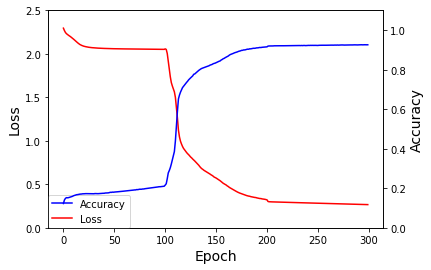

In [40]:
fig, ax1 = plt.subplots()
 
# ax1とax2を関連させる
ax2 = ax1.twinx()
 
# それぞれのaxesオブジェクトのlines属性にLine2Dオブジェクトを追加
ax1.plot(history.epoch, history.history["loss"],
         color='r', label="Loss")
ax2.plot(history.epoch, history.history["accuracy"], color='b',
        label="Accuracy")
 
# 凡例
# グラフの本体設定時に、ラベルを手動で設定する必要があるのは、barplotのみ。plotは自動で設定される＞
#handler1, label1 = ax1.get_legend_handles_labels()
#handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=3, borderaxespad=0.)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax2.set_ylabel('Accuracy', fontsize=14)
 
ax1.set_ylim([0, 2.5])
ax2.set_ylim([0, 1.1])

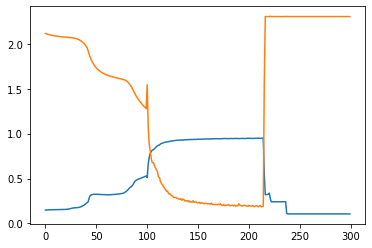

In [35]:
plt.plot(history.epoch, history.history["accuracy"], history.history["loss"])